# Semantic Scholar Network Generation
In this notebook, we'll explore building a citation network on results of a specific search using the Semantic Scholar API.

In [1]:
import requests
from tqdm import tqdm
import jsonlines
import json
import networkx as nx
from statistics import mean, median
from taxonerd import TaxoNERD
import taxoniq
import time
from numpy import cumsum
import matplotlib.pyplot as plt
%matplotlib inline

## Requesting Data
This is an example of how to request data for a citation network. 

In [2]:
# Import API key. This must be requested from https://www.semanticscholar.org/product/api#api-key; we save ours in an untracked file in data and import here
import sys
sys.path.append('../data/')
from semantic_scholar_API_key import API_KEY
header = {'x-api-key': API_KEY}

We want to look at the citations of papers that are returned when we search "desiccation tolerance" and "anhydrobiosis". We then want to use our previously written TaxoNERD code to get the study organisms and their kingdoms from the title ans abstracts. To do this, we need to build a query that will return some number of papers with title, abstract, and citations. A full reference of the properties we can request is found [here](https://api.semanticscholar.org/api-docs/#tag/Paper-Data/operation/get_graph_get_paper_search).

Using the API, only 99 papers can be requested at a time (maximum value of the `limit` parameter). However, we want to get thousands of search results (the maximum depth we can request into the search results is 10,000). We can do this by combining the `limit` and `offset` parameters; the `offset` parameter tells the request how far down the search results to start retrieving our 99 items.

In [3]:
# search_results = []
# for offset in tqdm(range(0, 10000, 100)):
#     query = f'http://api.semanticscholar.org/graph/v1/paper/search?query=desiccation+tolerance&offset={offset}&limit=99&fields=title,abstract,references'
#     search = requests.get(query, headers=header).json()
#     search_results.append(search)

Let's save our results as a jsonlines so we can come back to it without having to request:

In [4]:
# with jsonlines.open('../data/semantic_scholar/desiccation-tolerance_10000_24Aug2023.jsonl', 'w') as writer:
#     writer.write_all(search_results)

In [5]:
with jsonlines.open('../data/semantic_scholar/desiccation-tolerance_10000_24Aug2023.jsonl') as reader:
    search_results = []
    for obj in reader:
        search_results.append(obj)
# Flatten into one dict of just results
search_results = [p for res in search_results for p in res['data']]

We weren't able to get the abstracts for the citations when we originally pulled this information, so now let's get them secondarily:

In [6]:
# ref_dict = {}
# for search_subset in tqdm(search_results):
#     for paper in tqdm(search_subset['data']):
#         for ref in paper['references']:
#             query = f'http://api.semanticscholar.org/graph/v1/paper/{ref["paperId"]}?fields=title,abstract'
#             search = requests.get(query, headers=header).json()
#             ref_dict[paper["paperId"]] = search

The above cell is prohibitively slow (~70h to get all reference abstracts). Let's explore how to make this quicker. Our first hypothesis is that a large number of references are likely overlapping, so we may be able to massively scale down the operation by ignoring anything that's already been read. Let's quantify that:

In [7]:
refs = []
for paper in search_results:
    ref_ids = [ref['paperId'] for ref in paper['references']]
    refs.extend(ref_ids)

print(f'There are {len(refs)} total references, but only {len(set(refs))} are unique. This means we cut down our computation time on the order of {len(set(refs))/len(refs): .2f}')

There are 448657 total references, but only 187175 are unique. This means we cut down our computation time on the order of  0.42


Hey that's pretty good! however, that would stil be quite slow. I can also request multiple papers at once; would this make things more efficient? Let's use the `time` module to check. We want to get a sense of how the time scales with more instances included in a single request, compared to how long it would take to do each individually. We can make a plot to visualize this, using 20 references.

In [8]:
unique_20 = list(set(refs))[:20]
individual_times = {}
for i, u in enumerate(unique_20):
    query = f'http://api.semanticscholar.org/graph/v1/paper/{u}?fields=title,abstract'
    start = time.time()
    search = requests.get(query, headers=header).json()
    individual_times[i] = time.time() - start

In [9]:
together_times = {}
for i in range(len(unique_20)):
    start = time.time()
    search = requests.post('https://api.semanticscholar.org/graph/v1/paper/batch',
                          params={'fields': 'title,abstract'},
                          json={'ids': unique_20[:i+1]}).json()
    together_times[i] = time.time() - start

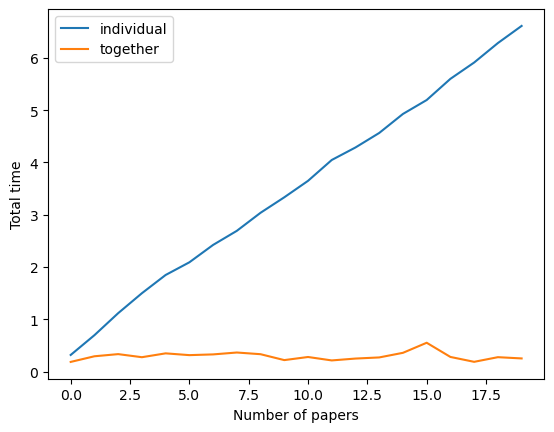

In [10]:
plt.plot(individual_times.keys(), cumsum(list(individual_times.values())), label='individual')
plt.plot(together_times.keys(), together_times.values(), label='together')
plt.xlabel('Number of papers')
plt.ylabel('Total time')
plt.legend()

That is an impressive speedup!! Woohoo! The limitation is that the post request can only take 500 paper ID's at a time, but that is still a substantial speedup from what I was doing before. After changing `pull_papers.py` to incorporate the post requests,the entire script, for all 10,000 search results, runs in about an hour. Let that serve as an example for why it's good to optimize things instead oif directly embarrasingly parallelizing them!

Read in output from `pull_papers.py`:

In [11]:
pull_path = '../data/semantic_scholar/desiccation-tolerance_10000_with_abstracts_for_refs_29Aug2023.json'
with open(pull_path) as myf:
    search_results = json.load(myf)

## Building citation network
We need to generate pairs of documents connected by citations. Conveniently, each paper has a unique ID generated by Semantic Scholar, which makes our lives somewhat easier.

To get the paper ID for a single search result:

In [12]:
search_results[0]['paperId']

'393cc126bd647a8435072e788a2a033561c6fa97'

To get the paper ID's of its references:

In [13]:
[p['paperId'] for p in search_results[0]['references']]

['18d8e54e9f384361d3f6af634642e82d2479bef2',
 '2ee8adf45800831679c9ee226cf108b34197108b',
 'af0eb5272536c8b1db53e671b77d9ea61e206ff5',
 '2b32eec751dbe123a7532cfac4fb3c8ce5295a37',
 '5f2084b6eb9286ee6930e2cc0d9e3c4f581def29',
 'efcbec4baa59b1cbe9acada9bbc266b020b1560f',
 '8f8622842a9d31cb7fff1ff4433c28bfd10133df',
 '9405079823b201c061eec9b85f184702289f0472',
 'c7937572a01f822d61d7f1b3eda5dfca10b06915',
 '12b1a3e2df680cd5a94ff89a356ef513f817cba9',
 '282bd0c59d247c35a1a0cbfd3708cd27bfcb9cbe',
 'b812c9a1370d125b91af265dbd2f417b4329a9df',
 'd79eedab7bae594f34c4d355510e57e2f21aecbe',
 'a52b0768702008d78d474fc431b95b2a0288fc65']

Characterizing average number of citations:

In [14]:
def characterize_citations(search_results):
    """
    Get statistics about the number of citations per paper.
    
    parameters:
        search_results, list of dict: query results
    """
    num_cites = []
    for paper in search_results:
        num_cites.append(len(paper['references']))
    print(f'Average number of citations per paper: {mean(num_cites): .2f}')
    print(f'Median number of citations per paper: {median(num_cites)}')
    print(f'Maximum number of citations per paper: {max(num_cites)}')
    print(f'Minimum number of citations per paper: {min(num_cites)}')

In [15]:
characterize_citations(search_results)

Average number of citations per paper:  45.19
Median number of citations per paper: 36.0
Maximum number of citations per paper: 1000
Minimum number of citations per paper: 0


Define a function to generate links:

In [16]:
def generate_links(search_results):
    """
    Generate a list of edges by paper ID from the results of a Semantic Scholar query.
    
    parameters:
        search_results, list of dict: query results
        
    returns:
        nodes, list of two-tuple: the paper ID and an attribute dictionary containing the paper's title
        edges, list of three-tuple: the paper IDs of both citing and cited paper, and an attribute dictionary with the paper's title
    """
    nodes, edges = [], []
    for paper in search_results:
        citing = (paper['paperId'], {'title': paper['title']})
        cited = [(p['paperId'], {'title': p['title']}) for p in paper['references']]   
        nodes.append(citing)
        nodes.extend(cited)
        edges.extend([(citing[0], p[0]) for p in cited])
    return nodes, edges

In [17]:
nodes, edges = generate_links(search_results)

Some citations appear to have been improperly formatted somewhere along the line, and result in having no paper ID, and a title that's just part of a full citation (not the actual title of the paper being cited). How many nodes of the network does this comprise?

In [18]:
print(f'{(sum([1 for n in nodes if n[0] is None])/len(nodes))*100: .2f}% of the network\'s nodes are malformed')

 8.84% of the network's nodes are malformed


This is a relatively small percentage -- let's drop them for now, we can come back and troubleshoot later. We also now want to add the taxonomic classification as attributes to nodes.

In [19]:
def classify_orgs(ents, defs):
    """
    Get organism classifications from a list of NCBI Taxonomy IDs

    parameters:
        ents, list of int: NCBI Taxonomy ID's
        defs, dict: keys are lineage categories, values are the final
            kingdom classification for those categories

    returns:
        kings, list of str: unique kingdom classifications
    """
    kings = []
    for i in ents:
        try:
            t1 = taxoniq.Taxon(i)
            lineage = [t.scientific_name for t in t1.ranked_lineage]
            if lineage[-1] == 'Bacteria' or lineage[-1] == 'Archea':
                kings.append(defs[lineage[-1]])
            elif lineage[-1] == 'Eukaryota':
                try:
                    kings.append(defs[lineage[-2]])
                except KeyError:
                    continue
        except KeyError:
            continue

    kings = list(set(kings))
    return kings

In [24]:
def classify_title(title, abstract, taxonerd):
    """
    Gets the Kingdom classification of a paper title.
    
    parameters:
        title, str: title of the paper
        abstract, str: abstract of the paper
        taxonerd, TaxoNERD instance: model to use for classification

    returns:
        king, str: kindgom of the paper
    """
    # Do TaxoNERD classification
    title_df = taxonerd.find_in_text(title)
    
    # Get the unique organisms
    title_ents = list(set([title_df['entity'][j][0][0].split("NCBI:")[1] for j in
            range(len(title_df))]))
    
    # Set up definitions for kingdom classification
    defs = {
            'Metazoa': 'Animal',
            'Viridiplantae': 'Plant', # Consider adding algae
            'Bacteria': 'Microbe',
            'Archea': 'Microbe'
            }
    
    # Classify unique organisms
    title_classes = classify_orgs(title_ents, defs)
    
    # If abstract isn't None, also classify abstract
    if abstract is not None:
        abstract_df = taxonerd.find_in_text(abstract)
        abstract_ents = list(set([abstract_df['entity'][j][0][0].split("NCBI:")[1] for j in
                range(len(abstract_df))]))
        abstract_classes = classify_orgs(abstract_ents, defs)
    else:
        abstract_classes = []
    
    # Get the kingdom
    if (len(title_classes) == len(abstract_classes) == 1) and (title_classes ==
            abstract_classes):
        king = title_classes[0]
    elif len(title_classes) == 0 and len(abstract_classes) == 1:
        king = abstract_classes[0]
    elif len(abstract_classes) == 0 and len(title_classes) == 1:
        king = title_classes[0]
    else:
        # For now, come back to this
        king = 'NOCLASS'
    return king


In [21]:
def generate_links_with_classification(search_results, taxonerd):
    """
    Generate a list of edges by paper ID from the results of a Semantic Scholar query. Removes malformed
    citations with no paperID, and classifies nodes by the organisms in their titles.
    
    parameters:
        search_results, dict: query results
        taxonerd, TaxoNERD instance: model to use for classification
        
    returns:
        nodes, list of two-tuple: the paper ID and an attribute dictionary containing the paper's title
        edges, list of three-tuple: the paper IDs of both citing and cited paper, and an attribute dictionary with the paper's title
    """
    
    # Classify nodes and identify edges
    nodes, edges = [], []
    i = 0
    for paper in tqdm(search_results):
        org = classify_title(paper['title'], paper['abstract'], taxonerd)
        citing = (paper['paperId'], {'title': paper['title'], 'study_system': org})
        cited = [(p['paperId'], {'title': p['title'], 'study_system': classify_title(p['title'], p['abstract'], taxonerd)}) for p in paper['references'] if p['paperId'] is not None]   
        nodes.append(citing)
        nodes.extend(cited)
        edges.extend([(citing[0], p[0], num) for num, p in enumerate(cited, i)])
        i += len(cited)
    return nodes, edges

In [22]:
# Define TaxoNERD model for classification
taxonerd = TaxoNERD(prefer_gpu=False)
nlp = taxonerd.load(model="en_core_eco_biobert", linker="ncbi_taxonomy", threshold=0.7)

The below cell is too memory intensive for my local machine, but there seem to be no bugs in the above code. Will transfer to a script and run as a job.

In [ ]:
# nodes, edges = generate_links_with_classification(search_results, taxonerd)

In [ ]:
citenet = nx.MultiDiGraph()
_ = citenet.add_nodes_from(nodes)
_ = citenet.add_edges_from(edges)

In [ ]:
nx.write_graphml(citenet, '../data/citation_network/network_des_10000_no_classification_25Aug2023.graphml')